# Wealth Maximization with Jumped Diffusion

## Parameters

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Model Parameters
r = 0.05
mu = 0.1
sigma = 0.2
lamb = 12.0 # lambda value as intensity of Poisson process
zeta = 50.0
gamma = -1.5
T = 2.0
X0 = 1.0

# Simulation parameters
M = 5 * (10 ** 3)
N = 200

## Utility Function

In [26]:
# The power utility function of parameter gamma with wealth process X
def utility(gamma,X):
    # Terminal wealth
    X_T = X[-1]
    return (X_T ** gamma) / gamma

## Simulate Poisson Arrival Times

In [27]:
# A function that simulates Poisson arrival times up to time T with intensity lambda
# Here use the property of Poisson process that its interarrival times are i.i.d. with exponantial distribution
# of parameter lambda
def get_Poisson_time(lamb,T):
    # A list to store arrival times
    arrival_time_lst = list()
    
    # If lambda is <= 0, always return the empty list
    if lamb <= 0:
        return arrival_time_lst
    
    while 1:
        # Sample of interarrival time
        r = np.random.exponential(scale = 1/lamb)
        
        if len(arrival_time_lst) == 0:
            # Empty list
            if r < T:
                # if happens before T then append
                arrival_time_lst.append(r)
            else:
                # else return the empty list
                return arrival_time_lst
        else:
            # Not empty list
            new_arrival = arrival_time_lst[-1] + r
            if new_arrival < T:
                # Arrival time not exceeding time T
                arrival_time_lst.append(new_arrival)
            else:
                # Exceeds time T, end of simulation
                return arrival_time_lst

In [28]:
# Test the function above
# The higher intensity of Poisson process, visits come more often, so there are more arrivals
print(get_Poisson_time(1,T))
print(get_Poisson_time(2,T))
print(get_Poisson_time(5,T))

[0.4954849810305921, 1.3339592138571297]
[0.2071352741430851, 0.6201018109023829, 0.920466724538892]
[0.2511188873670238, 0.40004859412422145, 0.4348601594950101, 0.7328378062098899, 0.8375354798632878, 1.1782892468856714, 1.2309006605845034, 1.2407107818987348, 1.3627725039238006, 1.471172577222766, 1.4934632292691157, 1.5716278753197694, 1.6310994441507398]


## Simulate Poisson Arrival Times and the Size of Jumps

In [29]:
# Get both time and size of the jump (tau and Y)
def get_Time_Size_Jump(lamb,T,zeta):
    # Simulate Poisson arrival times
    jump_time_lst = get_Poisson_time(lamb,T)
    # Number of jumps
    num_jumps = len(jump_time_lst)
    # Sample this number of Y's as jump size
    jump_size_lst = [np.random.exponential(scale = 1/zeta) for i in range(num_jumps)]
    return jump_time_lst,jump_size_lst

In [30]:
# Test the function above
# The sample mean of jump size is close to 2% = 1/zeta
jump_time_lst,jump_size_lst = get_Time_Size_Jump(lamb,T,zeta)
print(np.mean(jump_size_lst))
# The sample mean of the number of arrivals is close to 24 = lambda * T
print(len(jump_size_lst))

0.020482019465721646
32


## Euler Scheme Simulation

In [31]:
# Fix control pi
for pi in [0.5]:
    dt = T / N # Length of time interval
    
    # Store utility
    utility_sample = list()
    
    for _ in range(M):
        # Each Monte Carlo iteration
        
        # First determine the jump time and jump size as two lists
        jump_time_lst,jump_size_lst = get_Time_Size_Jump(lamb,T,zeta)
        num_jump = len(jump_time_lst)
        
        # Simulation
        X = np.zeros(N + 1)
        X[0] = X0
        
        for i in range(1,N + 1):
            # At time (i-1) * dt, value of X is X[i-1]
            X_value = X[i - 1]
            
            # Find the index of all jump time within the interval [(i-1) * dt,i * dt]
            jump_ind_lst = [ind for ind, value in enumerate(jump_time_lst) if value > (i - 1) * dt and value < i * dt]
            
            # A loop doing Euler scheme and jump updates alternatively
            last_jump_time = (i - 1) * dt # Record the last jump time
            while len(jump_ind_lst) > 0:
                jump_ind = jump_ind_lst[0]
                jump_time = jump_time_lst[jump_ind]
                jump_size = jump_size_lst[jump_ind]
                
                # Perform Euler scheme from last_jump_time to this jump_time
                # A Brownian motion increment
                W_incr = np.sqrt(jump_time - last_jump_time) * np.random.randn()
                X_value = X_value + X_value * (pi * mu + (1 - pi) * r) * (jump_time - last_jump_time) + \
                X_value * pi * sigma * W_incr
                
                # Perform a jump, ensure that it's positive
                X_value = np.maximum(X_value * (1 - pi * (np.exp(jump_size) - 1)),0)
                
                # Record the last jump time
                last_jump_time = jump_time
                
                # Remove the first index from list
                jump_ind_lst.pop(0)
            
            # After dealing with jumps, do Euler scheme from last_jump_time till i * dt
            W_incr = np.sqrt(i * dt - last_jump_time) * np.random.randn()
            X_value = X_value + X_value * (pi * mu + (1 - pi) * r) * (i * dt - last_jump_time) + \
            X_value * pi * sigma * W_incr
            
            # At time i * dt, value of X
            X[i] = X_value
            
        ## Plot the trajectory and the jumps to check the simulation
        #plt.plot(np.linspace(0,T,len(X)),X)
        #for jump_time in jump_time_lst:
            #plt.axvline(jump_time,linestyle = 'dashed',color = 'red')
        
        # Collect samples of utility
        utility_sample.append(utility(gamma,X),)
        
    # Take average as estimate of expected utility
    utility_est = np.mean(utility_sample)
    
    # Get the variance of the estimation
    regular_variance = np.std(utility_sample) ** 2
    
    print('When pi equals ' + str(pi) + ':')
    print('The expected utility is ' + str(utility_est))
    print('The variance is ' + str(regular_variance))

When pi equals 0.5:
The expected utility is -0.8080556991884912
The variance is 0.03833527617796325


## Find the Optimal Control

When there's no jump, under this set of parameters, $\pi=0.5$ is the optimal control. Now since there are jumps downward, we would expect the optimal control to be less than $0.5$.

In [32]:
# A list of all possible values for pi
pi_lst = np.linspace(0.0,0.5,50)

In [33]:
# Record the expected utility for each pi value
exp_utility_lst = list()

### Let all different $\pi$ share the same BM trajectory as variance reduction

In [34]:
# Prepare standard Gaussian increments xi first
Xi = np.random.randn(N + 1,M)

In [35]:
# Fix control pi
for pi in pi_lst:
    dt = T / N # Length of time interval
    
    # Store utility
    utility_sample = list()
    
    for MC_iter in range(M):
        # Each Monte Carlo iteration 
        # First determine the jump time and jump size as two lists
        jump_time_lst,jump_size_lst = get_Time_Size_Jump(lamb,T,zeta)
        num_jump = len(jump_time_lst)
        
        # Simulation
        X = np.zeros(N + 1)
        X[0] = X0
        
        for i in range(1,N + 1):
            # At time (i-1) * dt, value of X is X[i-1]
            X_value = X[i - 1]
            
            # Record the overall BM increment needed in this interval
            overall_W_incr = np.sqrt(dt) * Xi[i - 1,MC_iter]
            
            # Find the index of all jump time within the interval [(i-1) * dt,i * dt]
            jump_ind_lst = [ind for ind, value in enumerate(jump_time_lst) if value > (i - 1) * dt and value < i * dt]
            
            # A loop doing Euler scheme and jump updates alternatively
            last_jump_time = (i - 1) * dt # Record the last jump time
            while len(jump_ind_lst) > 0:
                jump_ind = jump_ind_lst[0]
                jump_time = jump_time_lst[jump_ind]
                jump_size = jump_size_lst[jump_ind]
                
                # Perform Euler scheme from last_jump_time to this jump_time
                # A Brownian motion increment
                W_incr = np.sqrt(jump_time - last_jump_time) * np.random.randn()
                # Notice that we have to minus this increment from overall increment
                overall_W_incr = overall_W_incr - W_incr
                X_value = X_value + X_value * (pi * mu + (1 - pi) * r) * (jump_time - last_jump_time) + \
                X_value * pi * sigma * W_incr
                
                # Perform a jump, ensure that it's positive
                X_value = np.maximum(X_value * (1 - pi * (np.exp(jump_size) - 1)),0)
                
                # Record the last jump time
                last_jump_time = jump_time
                
                # Remove the first index from list
                jump_ind_lst.pop(0)
            
            # After dealing with jumps, do Euler scheme from last_jump_time till i * dt
            # Use the prepared trajectory here!!!
            W_incr = overall_W_incr # The increments left for Euler scheme without jump
            X_value = X_value + X_value * (pi * mu + (1 - pi) * r) * (i * dt - last_jump_time) + \
            X_value * pi * sigma * W_incr
            
            # At time i * dt, value of X
            X[i] = X_value
            
        ## Plot the trajectory and the jumps to check the simulation
        #plt.plot(np.linspace(0,T,len(X)),X)
        #for jump_time in jump_time_lst:
            #plt.axvline(jump_time,linestyle = 'dashed',color = 'red')
        
        # Collect samples of utility
        utility_sample.append(utility(gamma,X),)
        
    # Take average as estimate of expected utility
    utility_est = np.mean(utility_sample)
    exp_utility_lst.append(utility_est)

The optimal pi is 0.0


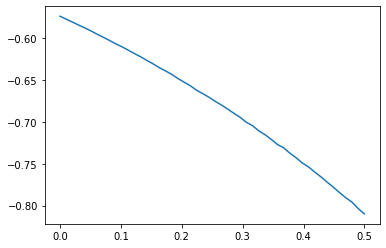

In [36]:
# Figure out the optimal control
opt_ind = np.argmax(exp_utility_lst)
opt_pi = pi_lst[opt_ind]
print('The optimal pi is ' + str(opt_pi))

# Plot the curve
plt.plot(pi_lst,exp_utility_lst)

When $\lambda = 0$, the code gives the optimal control $\pi = 0.5$, same as the closed-form solution to Merton problem without jumps.